In [1]:
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import integration as ig
import coordinates as coords
from matplotlib import interactive
interactive(True)
from sympy import symbols
from IPython.display import display
sy.init_printing(use_latex="png",scale=2)

# Definitions of: $t,r_s,x_1=r,x_2=\phi,\vec{x},\vec{v}$
The time $t$ is measured in units of $c$ for the analytic derivation

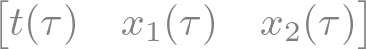

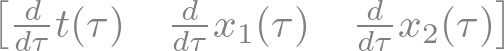

In [2]:
rs,tau = symbols('r_s,tau',real=True)
t = sy.Function("t",real=True)(tau)
x1 = sy.Function("x_1",real=True)(tau)
x2 = sy.Function("x_2",real=True)(tau)
x = sy.Array([t,x1,x2])
v = sy.Array([sy.diff(x[0],tau),sy.diff(x[1],tau),sy.diff(x[2],tau)])
display(x)
display(v)

# Definition of the Schwarzschild metric tensor $g_{\mu \nu}$
see https://en.wikipedia.org/wiki/Schwarzschild_metric#Formulation

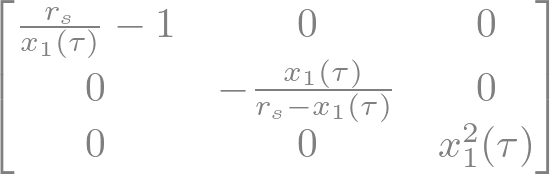

In [3]:
g = sy.Matrix([[-(1-rs/x1),0,0],[0,1/(1-rs/x1),0],[0,0,x1*x1]])
g = sy.simplify(g)
ndims = g.rows
display(g)

# Inverse metric tensor $g^{\mu \nu}$

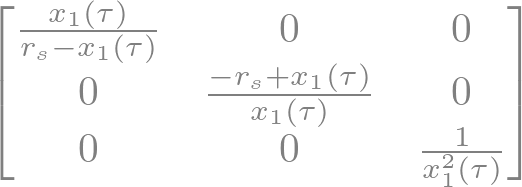

In [4]:
gi = g.inv()
#gi = sy.simplify(gi)
display(gi)

# Calculation of the Christoffel symbols $\Gamma^{i}{}_{kl}$
see https://en.wikipedia.org/wiki/Christoffel_symbols#Christoffel_symbols_of_the_second_kind_(symmetric_definition)

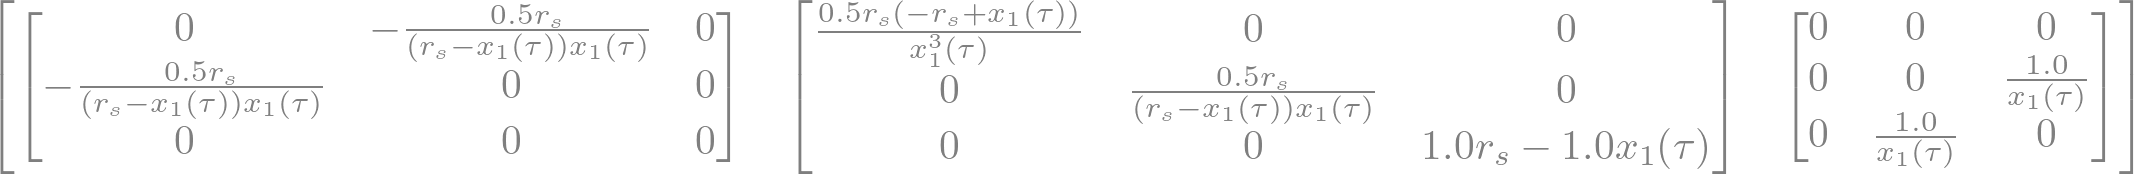

In [5]:
gamma = sy.MutableDenseNDimArray(np.zeros((ndims,ndims,ndims),dtype=int))
for i in range(ndims):
    for k in range(ndims):
        for l in range(ndims):
            for m in range(ndims):
                gamma[i,k,l] += 1/2*gi[i,m]*(sy.diff(g[m,k],x[l]) + sy.diff(g[m,l],x[k]) - sy.diff(g[k,l],x[m]))
gamma = sy.simplify(gamma)
display(gamma)

# Calculation of the 'acceleration' $\frac{\mathrm{d}^2 x^{\nu}}{\mathrm{d}\tau^2}$
see https://en.wikipedia.org/wiki/Geodesics_in_general_relativity#Mathematical_expression

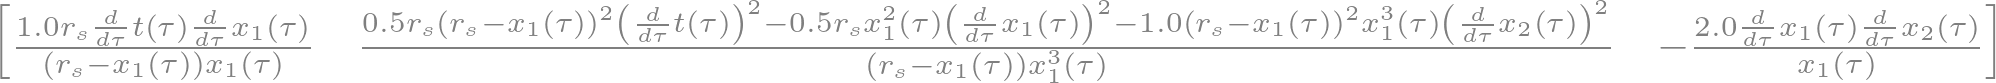

In [6]:
acc = sy.MutableDenseNDimArray(np.zeros((ndims),dtype=int))

for beta in range(ndims):
    for alpha in range(ndims):
        for mu in range(ndims):
            acc[mu] -= gamma[mu,alpha,beta]*v[alpha]*v[beta]

acc = sy.simplify(acc)
display(acc)

# Simple Example for $\phi = 0$, $\vec{v} = 0$

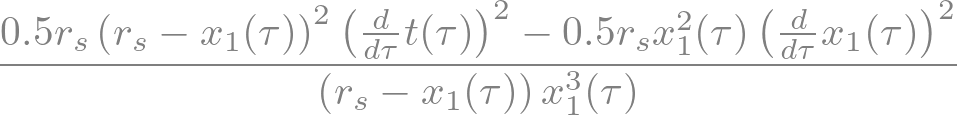

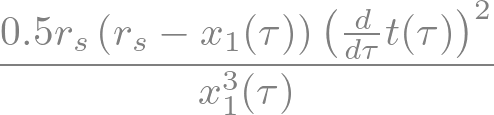

In [7]:
accR_simp = sy.simplify(acc[1].subs(x2,0))
display(accR_simp)
accR_simp = sy.simplify(accR_simp.subs(sy.diff(x[1],tau),0))
accR_simp = sy.simplify(accR_simp.subs(sy.diff(x[2],tau),0))
display(accR_simp)

### In this case: $\frac{\partial^2 r}{\partial \tau^2} = \frac{r_s (r_s - r)}{2 r^3} \cdot (\frac{\partial t}{\partial \tau})^2$
### With $r_s = \frac{2 G M}{c^2}$ being the Schwarzschild radius
### For $c \rightarrow \infty$ it follows: $\frac{\partial^2 r}{\partial t^2} = - \frac{G M}{r^2} + \frac{2 G^2 M^2}{c^2 r^3} + \mathcal{O}(c^{-3})$
### This corresponds to newtons law of gravitation.

# Setting the constants $G M$, $c$ and calculating $r_s$

In [8]:
GM_val = 1
c_val = 10
rs_val = 2*GM_val/c_val**2

# Transformation into cartesian coordinates
also the acceleration for newtonian gravity is defined, to make comparisons.

In [9]:
acct = sy.lambdify([t,x1,x2,v[0],v[1],v[2],rs],acc[0])
accx1 = sy.lambdify([t,x1,x2,v[0],v[1],v[2],rs],acc[1])
accx2 = sy.lambdify([t,x1,x2,v[0],v[1],v[2],rs],acc[2])


### TODO: 

def accF(t,x,y,vt,vx,vy):
    r,phi,_ = coords.conv_coords([x,y,0], "cartesian", "cylindrical")
    if r < rs_val:
        return (0,0)
    vr,vphi,_ = coords.conv_vec([x,y,0], [vx/c_val,vy/c_val,0], "cartesian", "cylindrical")
    tc, vtc = t/c_val, vt/c_val
    accr,accphi = accx1(r,phi,vr,vphi/r,rs_val)*c_val**2,accx2(r,phi,vr,vphi/r,rs_val)*r*c_val**2
    #print(accr,",",accphi)
    accx,accy,_ = coords.conv_vec([r,phi,0], [accr,accphi,0], "cylindrical", "cartesian")
    #print(r,",",phi)
    #print(vr,",",vphi)
    return (accx,accy)
    #return (accx1(x,y,vx,vy,c_val,rs_val),accx2(x,y,vx,vy,c_val,rs_val))
def accF_gravity(x,y,vx,vy):
    r = np.sqrt(x**2+y**2)
    return (-GM_val*x/r**3,-GM_val*y/r**3)

NameError: name 'x1t' is not defined

# Plot the quotient of the schwarzschild and newtonian acceleration

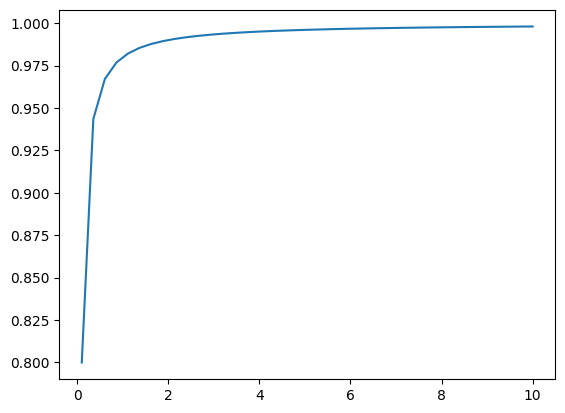

In [57]:
%matplotlib inline
testRs = np.linspace(0.1,10,40)
rel = []
for x in testRs:
    rel.append(accF(x,0,0,0)[0]/accF_gravity(x,0,0,0)[0])
plt.plot(testRs,rel)
plt.show()

# Calculate some geodesics

In [58]:
starts = []
for y in np.linspace(7.6,9,2):
    starts.append([0,y,-0.22,0.0])
for y in np.linspace(4.0,10,5):
    starts.append([20,y,-0.5,0.0])

trajectories = []
for start in starts:
    taus, infos = ig.get_geodesic(start[0],start[1],start[2],start[3],accF,dt=0.5,N=2000)
    trajectories.append(infos[:2])

out of bounds: integration stopped
out of bounds: integration stopped
out of bounds: integration stopped
out of bounds: integration stopped
out of bounds: integration stopped


# Plot the geodesics

/tmp/ipykernel_25253/3091362872.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


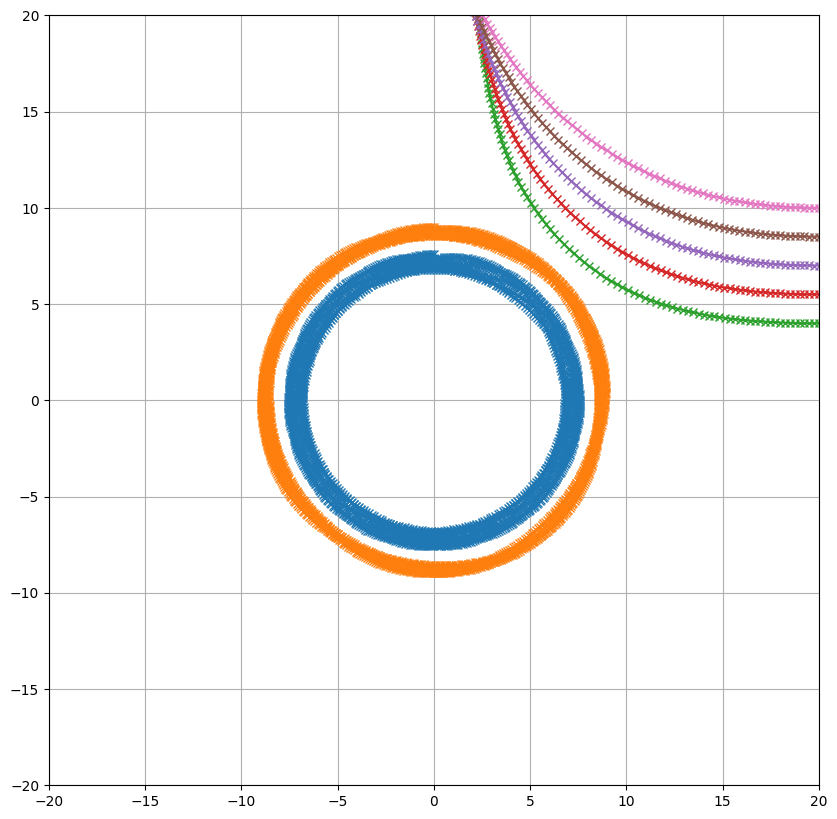

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_aspect(1.0)
for p in trajectories:
    ax.plot(p[0],p[1],marker="x")
vsize = 20
ax.set_xlim(-vsize,vsize)
ax.set_ylim(-vsize,vsize)
ax.grid()
fig.show()